### Comparing TF-IDF and CountVectorizer on a mlp classifier

#### Import libs

In [1]:

# sklearn (vectorizer, classifier, gridsearch)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt


# Auxiliary
import numpy as np
from random import shuffle

class TaggedPoint():
    def __init__(self, data, tag):
        self.data = data
        self.tag = tag


####  Import metadata

In [2]:
# opens the folder as per my file system and filters data based on rating and screen

with open("./norec/data/metadata.json", "r", encoding="utf-8") as file:
    data = json.load(file)  
    filtered_data = {k:v for k,v in data.items() if v["category"] == "screen"}
    #for k,v in filtered_data.items():
    #    print(k,v)

    neg_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [1,2,3]}
    pos_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [5,6]}
    
print(type(data))
print("Negative reviews: ", len(neg_reviews))
print("Positive reviews: ", len(pos_reviews))

<class 'dict'>
Negative reviews:  5246
Positive reviews:  5166


In [3]:
# takes the key values in the dictionary items and adds .txt to them for easy comparison in dev, test, train folder
# by adding the data as TaggedPoint-objects, we can easily reuse many of the supplied functions

import os
import os.path 

def get_files(path):
    global neg_reviews, pos_reviews
    id_neg = [k+".txt" for k in neg_reviews.keys()]
    id_pos = [k+".txt" for k in pos_reviews.keys()]
    data = []

    for file in os.listdir(path):
        fn = path+file
        if os.path.isfile(fn):
            if file in id_neg:
                with open(fn, "r", encoding="utf-8") as file:
                    content = file.read()
                    data.append(TaggedPoint(content, 0))
            elif file in id_pos:
                with open(fn, "r", encoding="utf-8") as file:
                    content = file.read()
                    data.append(TaggedPoint(content, 1))

    return data


test = get_files("./norec/data/test/")
val = get_files("./norec/data/dev/")
train = get_files("./norec/data/train/")

print(len(test), len(val), len(train))

1006 1054 8352


#### Shuffle the data

In [4]:
# not really necessary but it is considered good practice, just in case

def dj_shuffle_fricka_fricka(test, val, train):
    shuffle(test)
    shuffle(val)
    shuffle(train)
    return test, val, train

test_set, val_set, train_set = dj_shuffle_fricka_fricka(test, val, train)
#print(len(test), len(val), len(train))

#### Feature engineering: Both Tfidf and Count of tokens

In [5]:
# function that returns train features and feautres for both tfidf and countvectorizer

def get_train_features(train):
    #initialize the TF-IDF vectorizer and use the review data to vectorize
    vectorizer = TfidfVectorizer()
    #initialize the Count vectorizer and use the review data to vectorize
    c_vectorizer = CountVectorizer()

    X_train = vectorizer.fit_transform([review.data for review in train])
    X_train_c = c_vectorizer.fit_transform([review.data for review in train])

    y_train = np.array([review.tag for review in train])
    y_train_c = np.array([review.tag for review in train])

    return vectorizer, c_vectorizer, X_train, y_train, X_train_c, y_train_c


def get_features(data_set, vectorizer, c_vectorizer):
    #retrieve the features for parts of the data
    X = vectorizer.transform([review.data for review in data_set])
    y = np.array([review.tag for review in data_set])

    Z = c_vectorizer.transform([review.data for review in data_set])
    q = np.array([review.tag for review in data_set])
    return X, y, Z, q

#### GridSearch function for LR

In [6]:
# implementing grid search with different solvers and penalties with logistic regression
# increasing n_jobs to run more processes simultaneiously

def griddy_search(X, y):
    lr = LogisticRegression(max_iter=1500)

    params = {
        "penalty": [None, "l1", "l2"], 
        "class_weight": [None, "balanced"],
        "random_state": [0, 42],
        "solver": ["saga", "liblinear"],
    }

    clf = GridSearchCV(lr, params, n_jobs=5, verbose=2)   
    clf.fit(X,y)
    return clf 


def print_info(grid_result):
    print(grid_result)
    for p in grid_result.param_grid:
        print("\033[92m%20s \033[93m%-12s\033[0m %s" %
        (p, grid_result.best_params_[p], grid_result.param_grid[p]))

#### Function for hypertuning the params in the LR model 

In [39]:
# tuning-function that takes the params and training- and validation sets to give the result
# returns the classifier obejct along with displaying a matrix 

def make_best(params, X_train, y_train, X_val, y_val):
    lr = LogisticRegression(max_iter=1500,
                            penalty=params["penalty"],
                            class_weight=params["class_weight"],
                            random_state=params["random_state"],
                            solver=params["solver"])
    
    clf = lr.fit(X_train, y_train)

    print(clf.classes_)
    predictions = clf.predict(X_val)
    # print(predictions)

    print('\n\033[94mConfusion matrix:\033[0m\n',
          confusion_matrix(y_val, predictions, labels=[0, 1]))
    print(classification_report(y_val, predictions))
    
    cm = confusion_matrix(y_val, predictions, labels=[0,1])
    fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    fig.plot()
    #fig.figure_.suptitle("Confusion matrix for binary movie review classification")
    #plt.savefig("confusion.png", bbox_inches='tight')
    plt.show()

    return clf

#### Getting the features for Tf-Idf and CountVectorizer

In [8]:
# getting all the features with the tweaked functions

vectorizer, c_vectorizer, X_train, y_train, X_train_c, y_train_c = get_train_features(train_set)
X_val, y_val, X_val_c, y_val_c = get_features(val_set, vectorizer, c_vectorizer)
X_test, y_test, X_test_c, y_test_c = get_features(test_set, vectorizer, c_vectorizer)

In [9]:
# error checking to see if the sets are divided correctly

X_test.shape, y_test.shape, X_test_c.shape, y_test_c.shape 

((1006, 151073), (1006,), (1006, 151073), (1006,))

#### Running GridSearch on TD-IDF Vectorizer

In [10]:
%%time

grid_result = griddy_search(X_train, y_train)
print_info(grid_result)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1227, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(

GridSearchCV(estimator=LogisticRegression(max_iter=1500), n_jobs=5,
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['saga', 'liblinear']},
             verbose=2)
             penalty None         [None, 'l1', 'l2']
        class_weight None         [None, 'balanced']
        random_state 0            [0, 42]
              solver saga         ['saga', 'liblinear']


#### Running GridSearch on CountVectorizer

In [11]:
%%time

grid_result_c = griddy_search(X_train_c, y_train_c)
print(grid_result_c)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1227, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(

GridSearchCV(estimator=LogisticRegression(max_iter=1500), n_jobs=5,
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['saga', 'liblinear']},
             verbose=2)
CPU times: total: 312 ms
Wall time: 42min 2s


#### Finding best classifiers for grid search using TfidfVectorizer and CountVectorizer

[0 1]

Confusion matrix:
 [[453  68]
 [ 50 483]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       521
           1       0.88      0.91      0.89       533

    accuracy                           0.89      1054
   macro avg       0.89      0.89      0.89      1054
weighted avg       0.89      0.89      0.89      1054



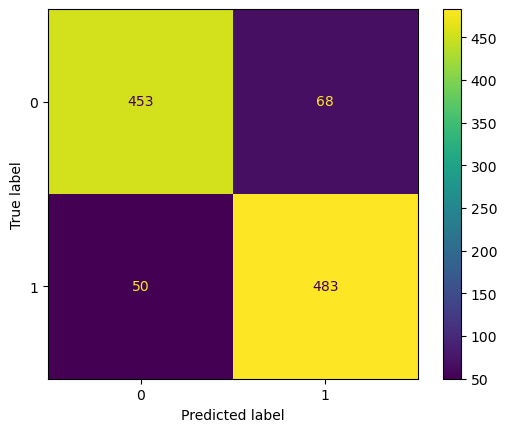

CPU times: total: 2.25 s
Wall time: 33.7 s


In [40]:
%%time 

best_classifier = make_best(grid_result.best_params_, X_train, y_train, X_val, y_val)

[0 1]

Confusion matrix:
 [[451  70]
 [ 60 473]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       521
           1       0.87      0.89      0.88       533

    accuracy                           0.88      1054
   macro avg       0.88      0.88      0.88      1054
weighted avg       0.88      0.88      0.88      1054



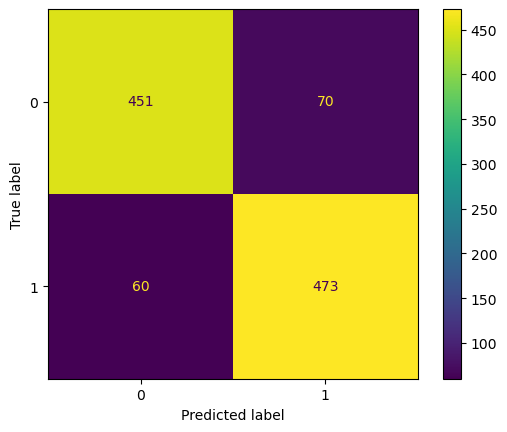

GridSearchCV(estimator=LogisticRegression(max_iter=1500), n_jobs=5,
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['saga', 'liblinear']},
             verbose=2)
             penalty l2           [None, 'l1', 'l2']
        class_weight balanced     [None, 'balanced']
        random_state 0            [0, 42]
              solver liblinear    ['saga', 'liblinear']
CPU times: total: 297 ms
Wall time: 1.84 s


In [46]:
%%time 

best_classifier_c = make_best(grid_result_c.best_params_, X_train_c, y_train_c, X_val_c, y_val_c)
print_info(grid_result_c)

### Feedforward Neural Networks 

### MLP Classifier function

In [37]:
# tweaked function that uses one more solver, several more hidden layers and increased computational power with n_jobs to run more efficiently

def train_mlp(X_train, y_train, X_val, y_val):
    mlp = MLPClassifier(max_iter=500)

    params = {
    "hidden_layer_sizes":(128, 64, 32, 16),
    "activation":"relu",
    "solver":["adam", "sgd"],
    "random_state":1
    }


    clf = GridSearchCV(mlp, params, n_jobs=4, verbose=2)
    clf = mlp.fit(X_train, y_train)


    print(clf.classes_)
    predictions = clf.predict(X_val)

    # print(predictions)
    conf_matrix = confusion_matrix(y_val, predictions, labels=[0, 1])
    print('\n\033[94mConfusion matrix:\033[0m\n', conf_matrix)
    print('\n\033[94mClassification report:\033[0m\n',classification_report(y_val, predictions))

    # display a confusion matrix
    fig = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=clf.classes_)
    fig.plot()
    plt.show()

    return clf

[0 1]

Confusion matrix:
 [[451  70]
 [ 47 486]]

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       521
           1       0.87      0.91      0.89       533

    accuracy                           0.89      1054
   macro avg       0.89      0.89      0.89      1054
weighted avg       0.89      0.89      0.89      1054



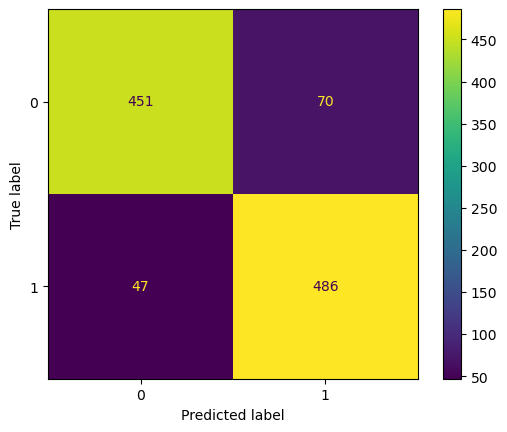

MLPClassifier(max_iter=500)
CPU times: total: 5min 44s
Wall time: 19min 22s


In [38]:
%%time 


grid_mlp = train_mlp(X_train, y_train, X_val, y_val)
print(grid_mlp)